In [1]:
import numpy as np
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from config import config

In [211]:
# Get data from DB

params = config()
conn = psycopg2.connect(**params)
cur = conn.cursor()
cur.execute("select * from dataentry_cifnepal as CIF inner join dataentry_personboxnepal as PB on CIF.id = PB.cif_id;")
colnames = [desc[0] for desc in cur.description]
rows = cur.fetchall()
df = pd.DataFrame(rows, columns = colnames)
cur.close()

In [212]:
# Data Processing / Create Unique Suspect ID number

dfcols = list(df.columns)
dfcols[16] = 'pv_occupation'
df.columns = dfcols

df['pb_number']=df['pb_number'].fillna(0).astype(int)
df['suspect_id'] = df['cif_number'].str.replace('.','')
df['suspect_id'] = df['suspect_id'].str[:-1] + ".PB" + df['pb_number'].map(str)
df = df.drop_duplicates(subset='suspect_id')
df.shape

(2256, 183)

In [224]:
#Remove columns that won't be used

df1 = df.drop(
    columns=[
        'id','date_time_entered_into_system','status','location','date_time_last_updated','staff_name',
        'informant_number','case_notes', 'pv_signed_form', 'consent_for_fundraising', 'guardian_name', 
        'guardian_phone', 'social_media', 'permission_contact_pv', 'permission_contact_whats_app', 
        'permission_contact_facebook', 'permission_contact_phone', 'legal_action_taken_filed_against', 
        'officer_name', 'cif_id', 'person_id', 'flag_count', 'main_pv_id', 'expected_earning',
        'expected_earning_currency','travel_expenses_paid_to_broker_amount','broker_relation',
        'travel_expenses_broker_repaid_amount','form_entered_by_id', 'source_of_intelligence', 
        'date_time_last_updated','interview_date','incident_date','how_recruited_broker_other',
        'legal_action_taken','legal_action_taken_case_type','appearance','date_visit_police_station',
        'victim_statement_certified_date','purpose_for_leaving_other','relation_to_pv',
        'exploitation_forced_prostitution_lb','exploitation_sexual_abuse_lb','exploitation_physical_abuse_lb',
        'exploitation_debt_bondage_lb','exploitation_forced_labor_lb',
        'associated_lb','exploitation_organ_removal_lb','exploitation_other_value','exploitation_other_lb',
    ])
df1.shape

(2256, 132)

In [225]:
#Add Arrest data

Arrests = pd.read_csv("Arrests.csv")
df1 = pd.merge(df1, Arrests, how='outer',on='suspect_id', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('x', 'y'), copy=True, indicator=False,
         validate=None)
df1.Arrest=df1.Arrest.fillna('0').astype(int)
df1 = df1.dropna(axis=0, subset=['cif_number'])

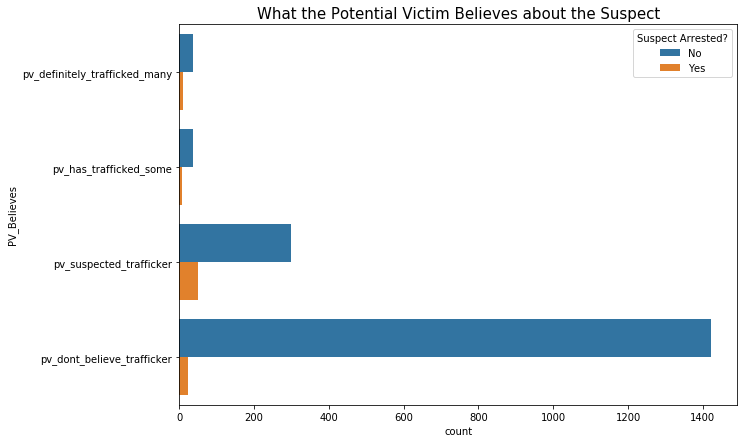

In [215]:
#EDA
#Look at total arrests by "potential victim believes" response

df2 = df1[['pv_definitely_trafficked_many', 'pv_has_trafficked_some', 'pv_suspected_trafficker', 
           'pv_dont_believe_trafficker', 'Arrest']]
df2 = pd.melt(df2, id_vars = ['Arrest'], value_vars = ['pv_definitely_trafficked_many', 'pv_has_trafficked_some', 
                                                       'pv_suspected_trafficker', 'pv_dont_believe_trafficker'],
                   var_name='PV_Believes', value_name='PV_BVal')
df2 = df2[df2.PV_BVal]

from matplotlib import pyplot

pdim=(10,7)
fig, ax = pyplot.subplots(figsize=pdim)
g = sns.countplot(ax=ax,y="PV_Believes", hue="Arrest",
                data=df2);
g.set_title("What the Potential Victim Believes about the Suspect",fontsize=15)
leg = g.get_legend()
leg.set_title("Suspect Arrested?")
labs = leg.texts
labs[0].set_text("No")
labs[1].set_text("Yes")

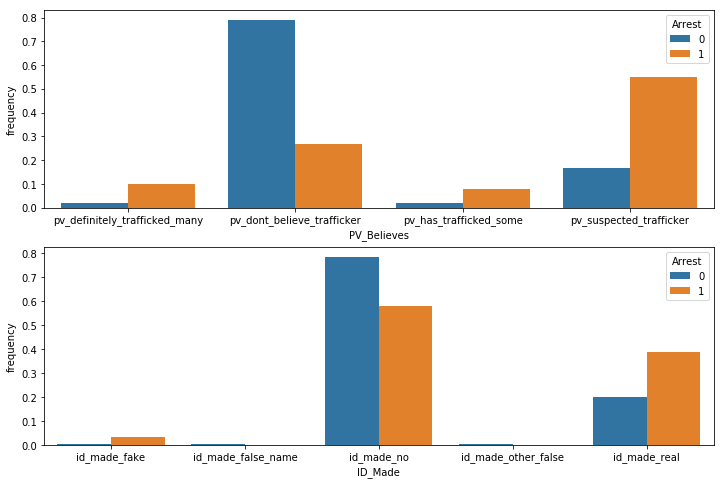

In [216]:
#EDA
#Look at percentage of arrests by "potential victim believes" and "ID Made" responses

df3 = pd.melt(df1, id_vars =['Arrest'], value_vars =['id_made_no','id_made_real','id_made_fake','id_made_false_name',
                                                     'id_made_other_false'],
              var_name='ID_Made', value_name='ID_Val')
df3 = df3[df3.ID_Val]
df2 = df2.set_index(['Arrest', df2.groupby('Arrest').cumcount()])
df3 = df3.set_index(['Arrest', df3.groupby('Arrest').cumcount()])
df4 = (pd.concat([df2, df3],axis=1)
         .sort_index(level=1)
         .reset_index(level=1, drop=True)
         .reset_index())

fig, axes = plt.subplots(2,1, figsize=(12,8))

df4['frequency'] = 0
for col, ax in zip(['PV_Believes','ID_Made'], axes.flatten()):
    counts = df4.groupby([col,'Arrest']).count()
    freq_per_group = counts.div(counts.groupby('Arrest').transform('sum')).reset_index()
    sns.barplot(x=col,y='frequency', hue='Arrest',data=freq_per_group,ax=ax)

In [226]:
#Feature Engineering

df1['planned_destination'] = df1['planned_destination'].str.replace(r'[^\w\s]+', '')
df1['destination_gulf'] = np.where(df1['planned_destination'].str.contains(
    'Gulf location|Kuwait|Dubai|UAE|Oman|Saudi|Iraq|Qatar|Bahrain'),True,False)
df1['destination_nepal'] = np.where(df1['planned_destination'].str.contains('Nepal'),True,False)
df1['destination_india'] = np.where(df1['planned_destination'].str.contains('India'),True,False)
df1['destination_delhi'] = np.where(df1['planned_destination'].str.contains('Delhi'),True,False)
df1['destination_gorakhpur'] = np.where(df1['planned_destination'].str.contains('Gorakhpur'),True,False)
df1['destination_bihar'] = np.where(df1['planned_destination'].str.contains('Bihar'),True,False)
df1['destination_mumbai'] = np.where(df1['planned_destination'].str.contains('Mumbai'),True,False)
df1['destination_sunauli'] = np.where(df1['planned_destination'].str.contains('Sunauli'),True,False)
df1['destination_banaras'] = np.where(df1['planned_destination'].str.contains('Banaras'),True,False)
df1['destination_kolkata'] = np.where(df1['planned_destination'].str.contains('Kolkata'),True,False)

PB_fields = [
    'id_source_pb','recruited_agency_pb','recruited_broker_pb','how_recruited_broker_online_pb','exploitation_sexual_abuse_pb',
    'how_recruited_broker_approached_pb', 'known_broker_pb','expected_earning_pb','exploitation_forced_prostitution_pb',
    'exploitation_forced_labor_pb','exploitation_organ_removal_pb','exploitation_other_pb','married_broker_pb',
    'travel_expenses_paid_by_broker_pb','travel_expenses_paid_by_broker_repaid_pb','travel_expenses_paid_to_broker_pb',
    'exploitation_physical_abuse_pb','exploitation_debt_bondage_pb',
]
## def func(x):
##    return x[0] in list(str(x[1]))
## for PBf in PB_fields:
##    df1[PBf + "2"] = df1[['pb_number', PBf]].apply(func, axis=1)

df1 = df1.drop(columns=['planned_destination','pb_number'])
df1 = df1.drop(columns = PB_fields)


In [227]:
#Organizing/preprocessing data

numerical_features = ['number_of_victims','number_of_traffickers','known_broker_years', 'known_broker_months',
                      'married_broker_years', 'married_broker_months','reported_blue_flags','total_blue_flags',
                      'suspected_trafficker_count']

categorical_features = ['education','guardian_relationship','station_id','role','pv_occupation','occupation']

boolean_features = list(
    set(list(df1.columns)) - set(numerical_features) - set(categorical_features))

df1[boolean_features] = df1[boolean_features].astype(bool)

df1[numerical_features] = df1[numerical_features].fillna(0).astype(float)

for f in categorical_features:
    df1[f] = df1[f].astype("category")

for cf in categorical_features:
    for elem in df1[cf].unique():
        df1[str(cf) + "_" + str(elem)] = df1[str(cf)] == elem
df1 = df1.drop(columns = categorical_features)

In [228]:
from sklearn.model_selection import train_test_split
X = (
    df1
    .drop(columns=['Arrest','Arrest_Date','cif_number','suspect_id'])
)
y = df1.Arrest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.125)

In [229]:
from sklearn.base import BaseEstimator, TransformerMixin

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [243]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

transformer = Pipeline([
    ('features', FeatureUnion(n_jobs=1, transformer_list=[
        ('boolean', Pipeline([
            ('selector', TypeSelector('bool')),
        ])),
        
        ('numericals', Pipeline([
            ('selector', TypeSelector(np.number)),
            ('scaler', StandardScaler()),
        ]))
    ])),
])

In [244]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

sgdclassifier_pipeline = Pipeline([
    ('transformer', transformer),
    ('sgdclassifier', SGDClassifier()),
])

rfclassifier_pipeline = Pipeline([
    ('transformer', transformer),
    ('rfclassifier', RandomForestClassifier())
])

In [249]:
sgdclassifier_pipeline.fit(X_train, y_train)
y_score_sgd = sgdclassifier_pipeline.decision_function(X_validation)
rfclassifier_pipeline.fit(X_train, y_train)
y_score_rf = rfclassifier_pipeline.predict(X_validation)

C:\Users\RandA\Anaconda3\envs\py36_32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

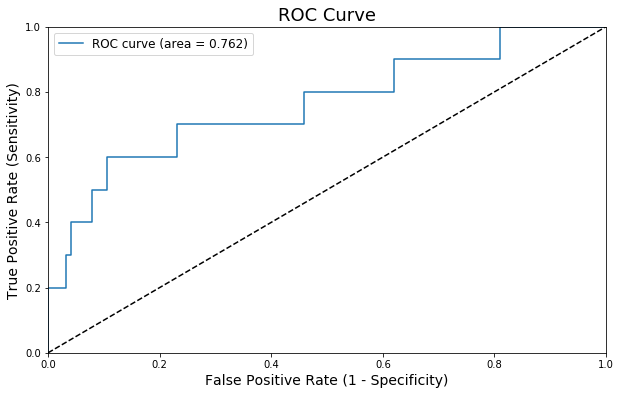

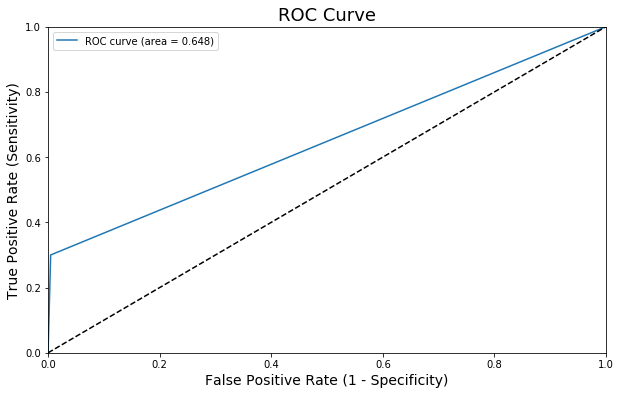

In [252]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

plt.figure(0).clf()

fpr, tpr, thresholds = roc_curve(y_validation, y_score_sgd)
roc_auc = roc_auc_score(y_validation, y_score_sgd)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=14)
plt.ylabel('True Positive Rate (Sensitivity)', size=14)
plt.title('ROC Curve', size=18)
plt.legend(fontsize=12)

fpr, tpr, thresholds = roc_curve(y_validation, y_score_rf)
roc_auc = roc_auc_score(y_validation, y_score_rf)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=14)
plt.ylabel('True Positive Rate (Sensitivity)', size=14)
plt.title('ROC Curve', size=18)
plt.legend(fontsize=12)

plt.legend(loc=0);

In [234]:
parameters = {
    'sgdclassifier__alpha': (0.00001, 0.000001),
    'sgdclassifier__penalty': ('l1','l2', 'elasticnet'),
    'sgdclassifier__n_iter':(100, 1000)
}

In [235]:
from sklearn.model_selection import GridSearchCV
from time import time

if __name__ == "__main__":
    grid_search = GridSearchCV(classifier_pipeline, parameters, cv=5,
                               n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in classifier_pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['transformer', 'sgdclassifier']
parameters:
{'sgdclassifier__alpha': (1e-05, 1e-06), 'sgdclassifier__penalty': ('l1', 'l2', 'elasticnet'), 'sgdclassifier__n_iter': (100, 1000)}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.4min finished
C:\Users\RandA\Anaconda3\envs\py36_32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


done in 147.202s

Best score: 0.941
Best parameters set:
	sgdclassifier__alpha: 1e-06
	sgdclassifier__n_iter: 100
	sgdclassifier__penalty: 'l2'


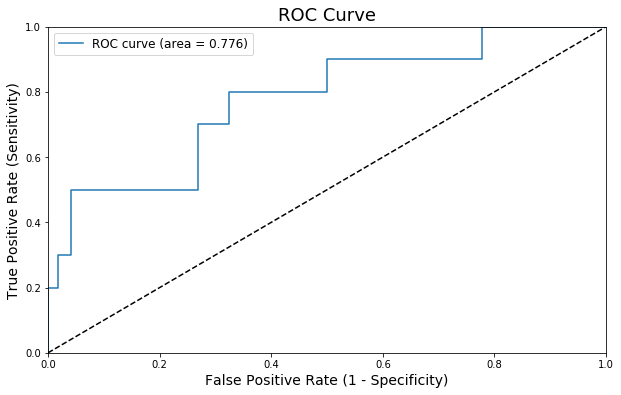

In [236]:

y_score = grid_search.decision_function(X_validation)

fpr, tpr, thresholds = roc_curve(y_validation, y_score)
roc_auc = roc_auc_score(y_validation, y_score)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=14)
plt.ylabel('True Positive Rate (Sensitivity)', size=14)
plt.title('ROC Curve', size=18)
plt.legend(fontsize=12);

In [210]:
#dest_top_freq = df1.groupby(['planned_destination'])['planned_destination'].agg(
#    {"dest_count": len}).sort_values(
#    "dest_count", ascending=False).head(20).reset_index()
#dest_top_freq